## Internation Footbal Match Prediction

#### Importing libraries

In [111]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data management
import pandas as pd
import numpy as np
import pickle as pkl

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, InputLayer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, mean_squared_error


### Datasets

In [238]:
df = pd.read_csv('data/results.csv', parse_dates=['date'])
results = df.copy()
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [239]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47126 entries, 0 to 47125
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        47126 non-null  datetime64[ns]
 1   home_team   47126 non-null  object        
 2   away_team   47126 non-null  object        
 3   home_score  47087 non-null  float64       
 4   away_score  47087 non-null  float64       
 5   tournament  47126 non-null  object        
 6   city        47126 non-null  object        
 7   country     47126 non-null  object        
 8   neutral     47126 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(5)
memory usage: 2.9+ MB


In [240]:
# Filter out futue games
results = results[~results['home_score'].isnull()]
# Change neutral column from boolean to integer
results['neutral'] = results['neutral'].apply(lambda x: 1 if x else 0)
# Change countries that no longer exists
countries = {'Czechoslovakia': 'Czech Republic', 'Soviet Union': 'Russia', 'Yugoslavia': 'Serbia', 'German DR': 'Germany'}
results = results.replace({'home_team': countries, 'away_team': countries})
# Create column for days since the game
results['days_since'] = (pd.to_datetime('now') - results.date).dt.days

* There are $47126$ entries but only $47075$ are from past results.

In [6]:
results.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,47075,NaN,NaN,NaN,1992-12-01 22:34:15.460435456,1872-11-30 00:00:00,1979-06-16 12:00:00,1999-06-05 00:00:00,2011-10-11 00:00:00,2024-03-26 00:00:00,NaN
home_team,47075,325,Germany,667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
away_team,47075,320,Germany,632,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_score,47075.0,NaN,NaN,NaN,1.76119,0.0,1.0,1.0,2.0,31.0,1.776751
away_score,47075.0,NaN,NaN,NaN,1.183452,0.0,0.0,1.0,2.0,21.0,1.402597
tournament,47075,174,Friendly,17902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,47075,2058,Kuala Lumpur,724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,47075,271,United States,1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neutral,47075.0,NaN,NaN,NaN,0.262539,0.0,0.0,0.0,1.0,1.0,0.440018
days_since,47075.0,NaN,NaN,NaN,11516.059543,79.0,4629.0,9140.0,16433.5,55347.0,9135.577545


In [ ]:
for comp, value in results['tournament'].value_counts().items():
    if value > 100:
        print(comp, value)

In [241]:
# Create column if the tourname is official or not
# Tournaments consider official are fiven an arbitrary value depending on the importance, the unofficial games are given 1 point
official = {
    'FIFA World Cup': 10,
    'Confederations Cup': 8,
    'UEFA Euro': 7,
    'Copa América': 7,
    'FIFA World Cup qualification': 6,
    'FIFA World Cup qualification': 6,
    'African Cup of Nations': 4,
    'African Cup of Nations': 4,
    'CONCACAF Nations League': 0,
    'UEFA Euro qualification': 4,
    'UEFA Nations League': 3,
    'African Cup of Nations qualification': 1
}
results['is_official'] = results['tournament'].apply(lambda x: official.get(x, 1))

# Coluimn if the home team won  (1 home won, 0 draw, -1 away won)
results['winner'] = np.select([results['home_score'] > results['away_score'], results['home_score'] == results['away_score'], results['home_score'] < results['away_score']], [1, 0, -1])

results.sample(6)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,days_since,is_official,winner
9355,1973-07-29,India,Thailand,2.0,0.0,Merdeka Tournament,Kuala Lumpur,Malaysia,1,18588,1,1
26928,2003-02-13,Costa Rica,Guatemala,1.0,1.0,UNCAF Cup,Panama City,Panama,1,7797,1,0
36368,2012-11-14,Andorra,Iceland,0.0,2.0,Friendly,Sant Julià de Lòria,Andorra,0,4235,1,-1
15174,1986-03-11,Bahrain,Iceland,2.0,1.0,Friendly,Manama,Bahrain,0,13980,1,1
840,1924-04-06,Hungary,Italy,7.0,1.0,Friendly,Budapest,Hungary,0,36599,1,1
18233,1992-06-03,Faroe Islands,Belgium,0.0,3.0,FIFA World Cup qualification,Toftir,Faroe Islands,0,11704,6,-1


### Create H2H entry

In [242]:
def h2h(row: pd.Series) -> int:
    """Calculate the last 5 official games h2h and assign -3 for each away victory and 3 for home victory"""
    date, home, away = row['date'], row['home_team'], row['away_team']
    games = results[(results.date < date) & (results.is_official > 1) &\
        (((results['home_team']==home) & (results['away_team']==away)) |\
            ((results['home_team']==away) & (results['away_team']==home)))].sort_values(by=['date'], ascending=False).head()
    return games.apply(lambda x: 3 if ((x.winner==1 and x.home_team==home) or (x.winner==-1 and x.away_team==home)) else \
        -3 if ((x.winner==-1 and x.away_team==away) or (x.winner==1 and x.home_team==away)) else 0, axis=1).sum()

results['h2h'] = results.apply(h2h, axis=1)

### Performance of the teams

In [243]:
def calculate_performances(data: pd.DataFrame) -> pd.DataFrame:
    # Creating the performance dataset
    performance = pd.DataFrame({'team': data['home_team'].unique()})
    
    def calculate_stats_per_team(row: pd.Series) -> pd.Series:
        games = data[(results['home_team']==row.team) | (results['away_team']==row.team)]
        # Games and importance per game
        total_games, importance = (games.agg(games=('is_official', 'count'), games_importance=('is_official', sum)).T.reset_index(drop=True)).iloc[0].tolist()  
        # games_importance = total_games * importance  
        # Current team form
        form = games[(results['is_official']>0)].sort_values(by='date', ascending=False).head(5).apply(
            lambda x: 3 if (x['home_team']==row.team and x['winner']==1) or (x['away_team']==row.team and x['winner']==-1) \
            else 1 if x['winner']==0 else 0, axis=1).sum(axis=0) or 0
        # Neutral stats
        return pd.Series([total_games, importance, form])
    performance[['games', 'games_importance', 'form']] = performance.apply(calculate_stats_per_team, axis=1)
    
    # Add home and away stats
    for suf, win, con in [('home', 1, 'away'), ('away', -1, 'home')]:
        # Calculate wins of the team -- & (data['neutral']==False)
        agg = {f'{suf}_wins': ('winner', 'count'), f'{suf}_importance': ('is_official', sum)}
        wins = data[(data['winner']==win) & (data['neutral']==0)].groupby(
            by=[f'{suf}_team'], as_index=False).agg(**agg).rename(columns={f'{suf}_team':'team'})
        # wins[f'{suf}_importance'] = wins[f'{suf}_wins'] * wins[f'{suf}_importance']
        performance = performance.merge(wins, on='team', how='left').fillna(0)
        # Calculate losses
        loss = data[(data['winner']==-win) & (data['neutral']==0)].groupby(
            by=[f'{suf}_team'])['winner'].count().reset_index().rename(columns={f'{suf}_team':'team', 'winner': f'{suf}_loses'})
        performance = performance.merge(loss, on='team', how='left').fillna(0)
        # Goals for the team
        kwargs = {f'{suf}_gf': (f'{suf}_score', 'sum'), f'{suf}_ga': (f'{con}_score', 'sum'), f'{suf}_avg_goals': (f'{suf}_score', np.mean)}
        goals = data[(data['neutral']==0)].groupby(by=[f'{suf}_team'], as_index=False).agg(**kwargs).rename(columns={f'{suf}_team': 'team'})  
        performance = performance.merge(goals, on='team', how='left').fillna(0)      
    
    # Add neutral venues stats
    for suf, win, con in [('home', 1, 'away'), ('away', -1, 'home')]:
        # Calculate wins of the team -- & (data['neutral']==False)
        agg = {f'{suf}_neutral_wins': ('winner', 'count'), f'{suf}_neutral_importance': ('is_official', sum)}
        wins = data[(data['winner']==win) & (data['neutral']==1)].groupby(
            by=[f'{suf}_team'], as_index=False).agg(**agg).rename(columns={f'{suf}_team':'team'})
        performance = performance.merge(wins, on='team', how='left').fillna(0)
        # Calculate losses
        loss = data[(data['winner']==-win) & (data['neutral']==1)].groupby(
            by=[f'{suf}_team'])['winner'].count().reset_index().rename(
                columns={f'{suf}_team':'team', 'winner': f'{suf}_neutral_loses'})
        performance = performance.merge(loss, on='team', how='left').fillna(0)
        # Goals for the team
        kwargs = {f'{suf}_neutral_gf': (f'{suf}_score', 'sum'), f'{suf}_neutral_ga': (f'{con}_score', 'sum'), f'{suf}_neutral_avg_goals': (f'{suf}_score', np.mean)}
        goals = data[(data['neutral']==1)].groupby(by=[f'{suf}_team'], as_index=False).agg(**kwargs).rename(columns={f'{suf}_team': 'team'})  
        performance = performance.merge(goals, on='team', how='left').fillna(0)    

    # Add performance (total wins / total games)
    performance['performance'] = (performance['home_importance'] + performance['home_neutral_importance'] +\
        performance['away_importance'] + performance['away_neutral_importance']) / performance['games_importance']

    return performance

In [244]:
total_performance = calculate_performances(results)
official_performance = calculate_performances(results[results['is_official']>1])

In [245]:
important_performance = calculate_performances(results[results['is_official']>=6])

In [246]:
recent_performance = calculate_performances(results[results['date'].dt.year>=1990])

In [247]:
euros_performance = calculate_performances(results[results['tournament']=='UEFA Euro'])

In [248]:
euros_performance.head()

,team,games,games_importance,form,home_wins,home_importance,home_loses,home_gf,home_ga,home_avg_goals,...,home_neutral_gf,home_neutral_ga,home_neutral_avg_goals,away_neutral_wins,away_neutral_importance,away_neutral_loses,away_neutral_gf,away_neutral_ga,away_neutral_avg_goals,performance
0,Czech Republic,38,266,4,0.0,0.0,0.0,0.0,0.0,0.000000,...,19.0,23.0,1.266667,6.0,42.0,6.0,23.0,23.0,1.437500,0.394737
1,France,44,308,9,10.0,70.0,3.0,31.0,16.0,2.214286,...,18.0,14.0,1.285714,5.0,35.0,3.0,14.0,15.0,1.272727,0.500000
2,Russia,36,252,3,1.0,7.0,1.0,1.0,3.0,0.500000,...,17.0,20.0,1.416667,7.0,49.0,7.0,19.0,20.0,1.117647,0.361111
3,Denmark,34,238,10,1.0,7.0,2.0,5.0,4.0,1.666667,...,19.0,19.0,1.461538,6.0,42.0,5.0,18.0,19.0,1.384615,0.294118
4,Spain,47,329,11,3.0,21.0,0.0,10.0,3.0,2.000000,...,26.0,8.0,1.857143,11.0,77.0,4.0,35.0,26.0,1.521739,0.468085


### Exploratory Analysis

<Axes: >

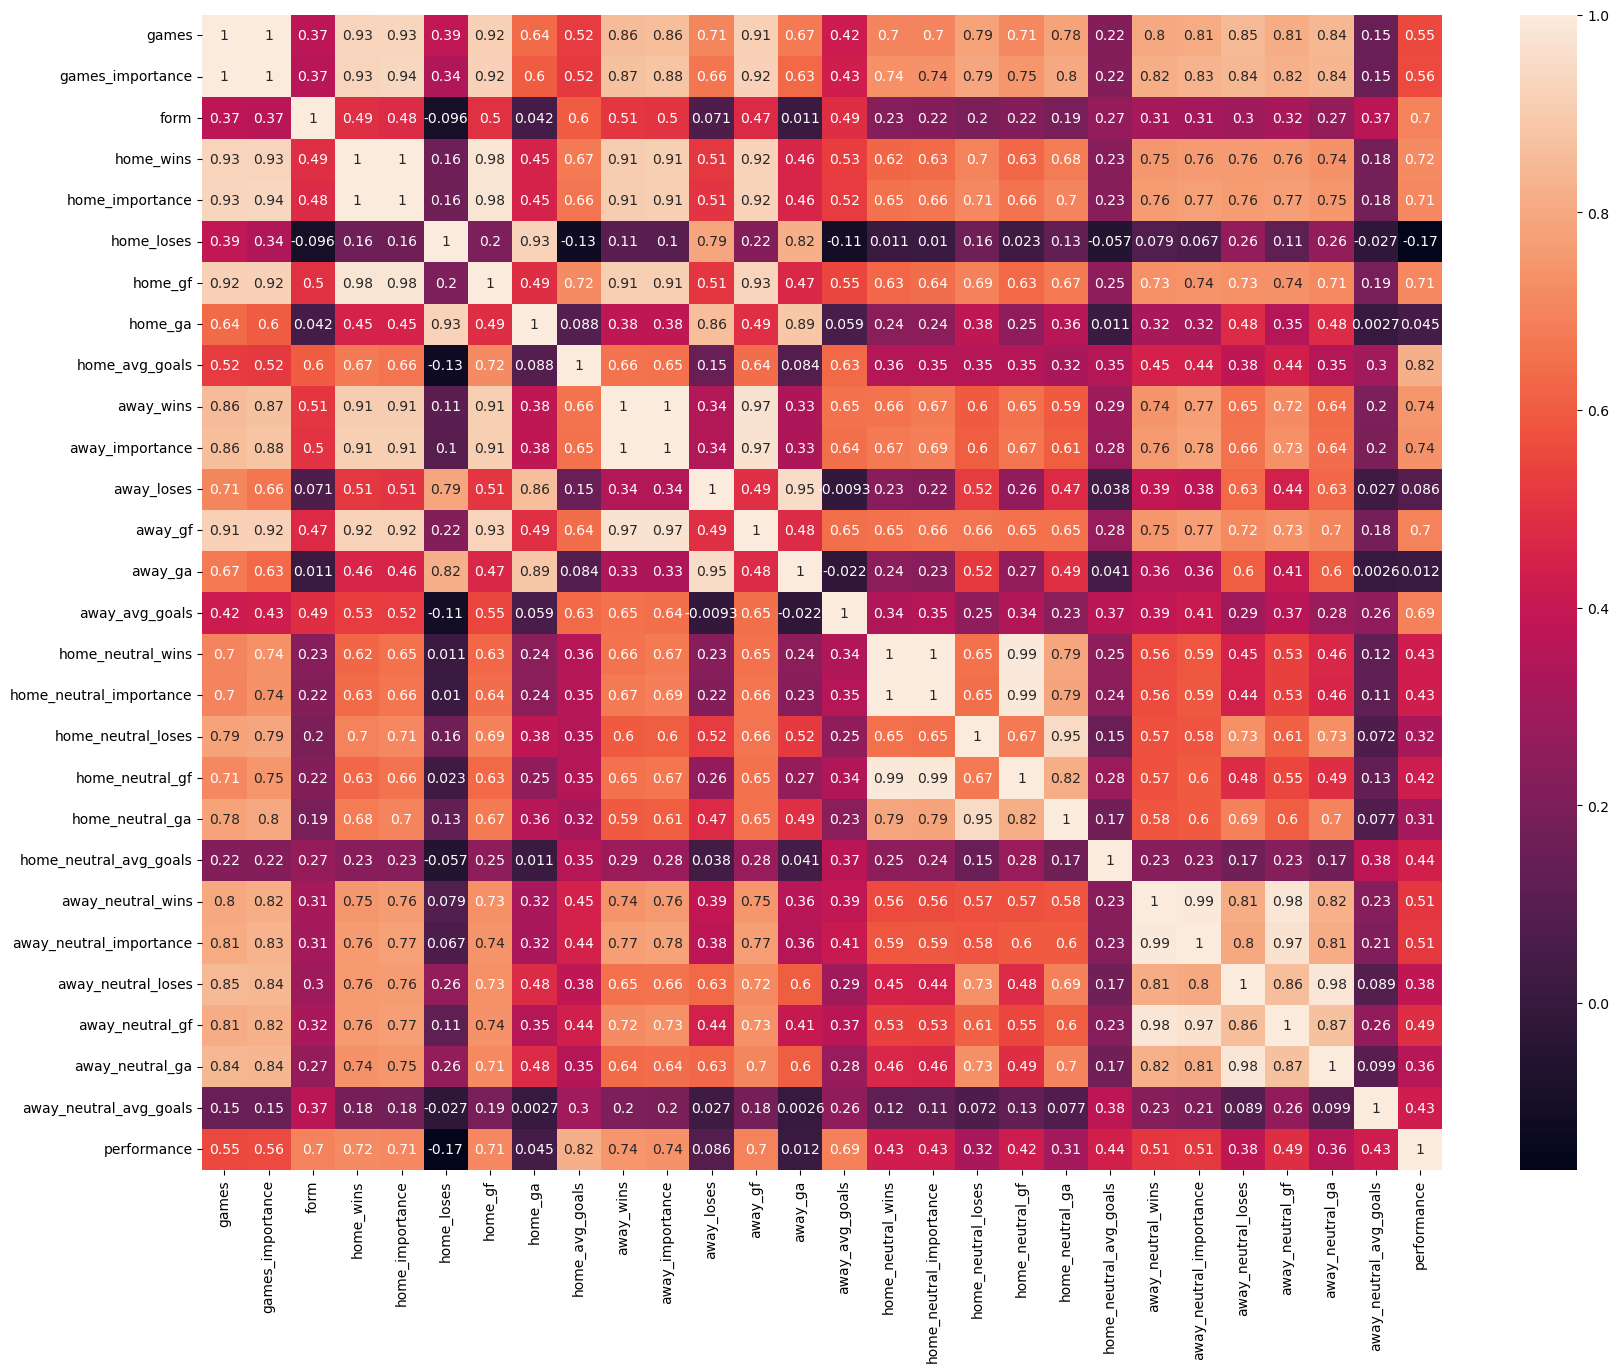

In [17]:
plt.figure(figsize=(20, 15))
sns.heatmap(important_performance[[col for col  in important_performance.select_dtypes(include=['int', 'float']).columns.values]].corr(), annot=True)

#### Home winners

Text(0.5, 1.0, 'Games winner in Non-Neutral Venues')

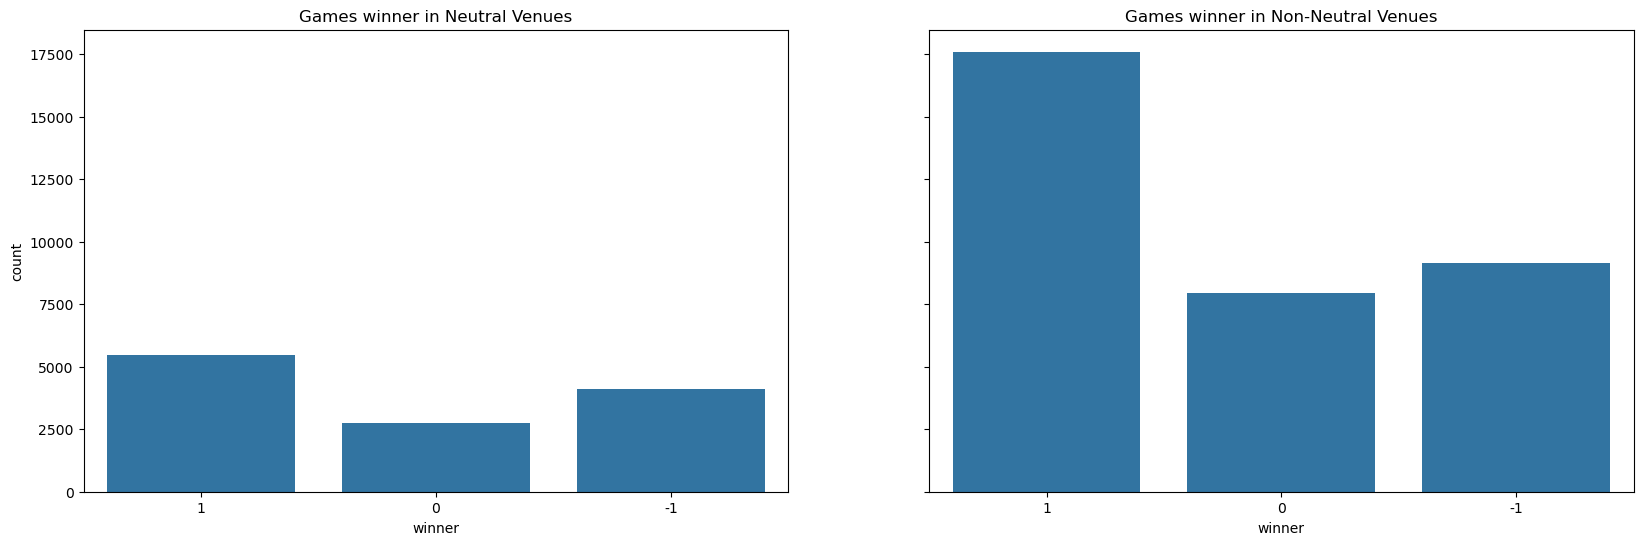

In [18]:
_, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
sns.countplot(results[results['neutral']==True], x='winner', order=[1, 0, -1], ax=axs[0])
axs[0].set_title('Games winner in Neutral Venues')
sns.countplot(results[results['neutral']==False], x='winner', order=[1, 0, -1], ax=axs[1])
axs[1].set_title('Games winner in Non-Neutral Venues')

#### Succesful countries

Text(0.5, 1.0, 'Top 25 countries performances')

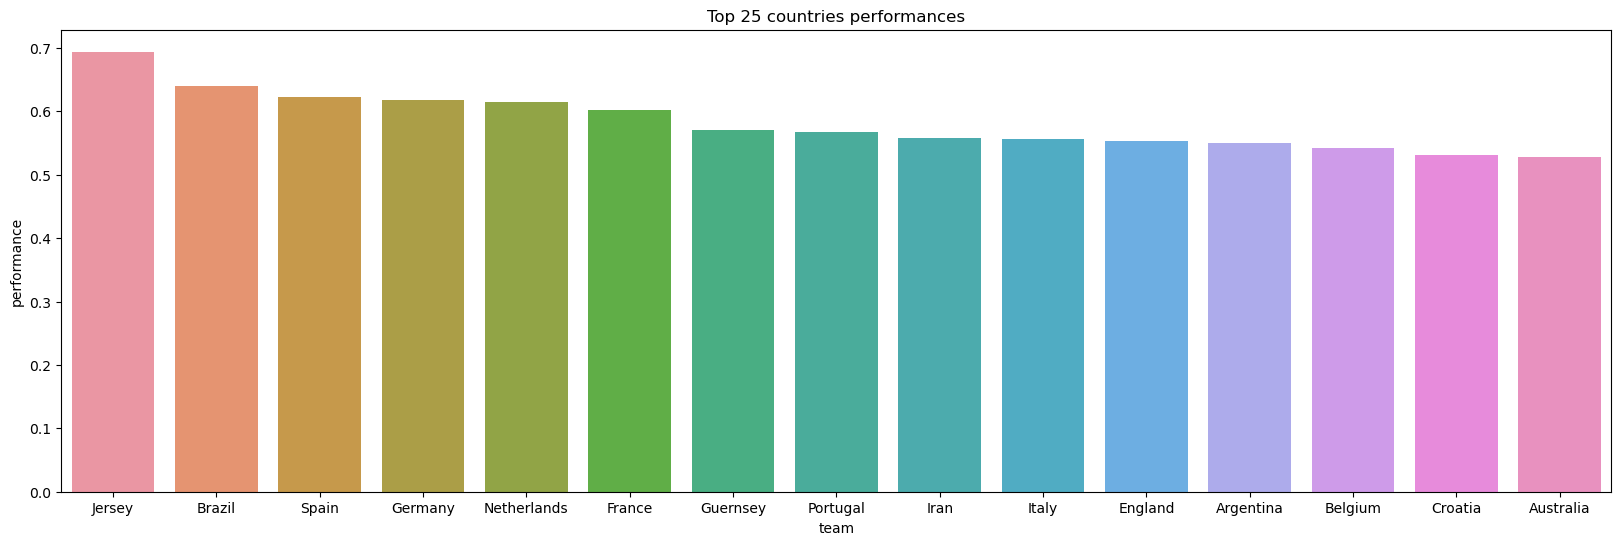

In [404]:
plt.figure(figsize=(20, 6))
sns.barplot(recent_performance[recent_performance['games']>100].sort_values(by='performance', ascending=False).head(15), x='team', y='performance')

plt.title('Top 25 countries performances')

Text(0.5, 1.0, 'Top 25 countries with more important games')

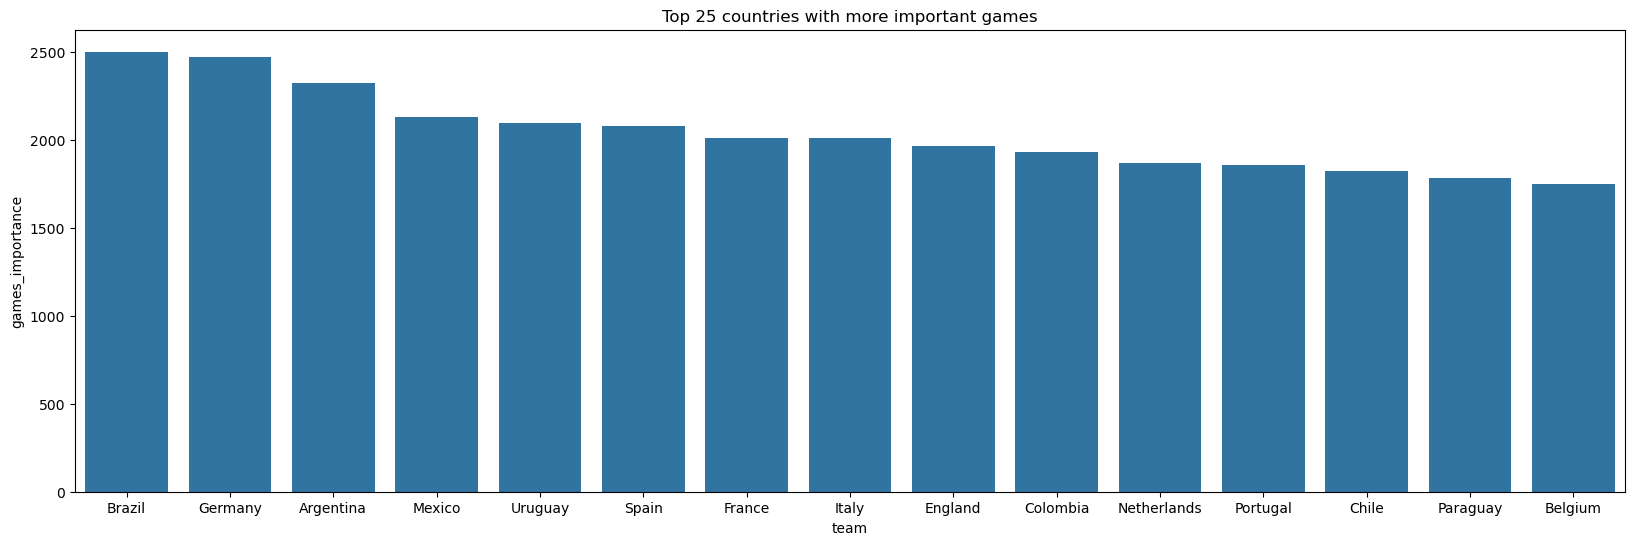

In [232]:
plt.figure(figsize=(20, 6))
sns.barplot(recent_performance[recent_performance['games']>100].sort_values(by='games_importance', ascending=False).head(15), x='team', y='games_importance')

plt.title('Top 25 countries with more important games')

Text(0.5, 1.0, 'Top 25 countries in UEFA Euro')

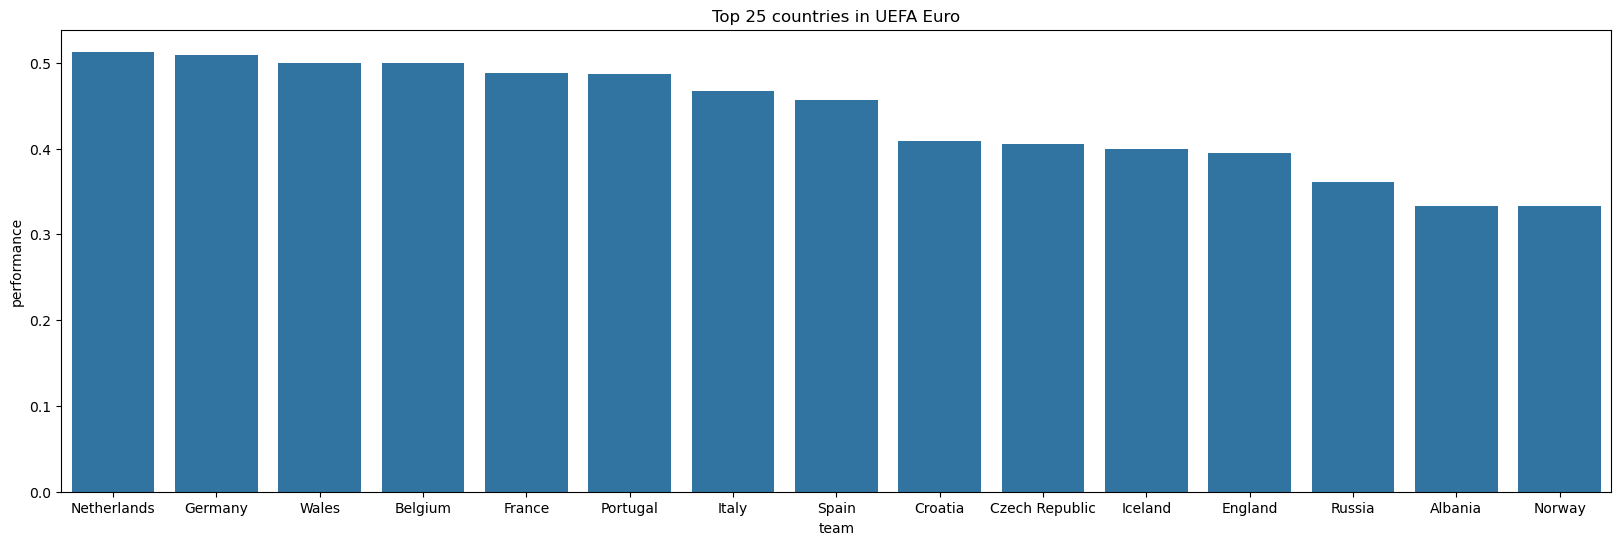

In [233]:
plt.figure(figsize=(20, 6))
sns.barplot(euros_performance.sort_values(by='performance', ascending=False).head(15), x='team', y='performance')

plt.title('Top 25 countries in UEFA Euro')

### Preparing input for modeling

#### Create the input dataframe

In [249]:
# Filter out older results
res = results[results['date'].dt.year>=1990]
res = results[results['is_official']>=6]
df_input = res[['home_team', 'away_team', 'winner', 'home_score', 'away_score', 'is_official', 'neutral', 'h2h']]
df_input = df_input.merge(important_performance, left_on='home_team', right_on='team', how='left').fillna(0).merge(
    important_performance, left_on='away_team', right_on='team', how='left', suffixes=['_home', '_away']).fillna(0).drop(
        ['team_home', 'team_away'], axis=1)

print(df_input.shape)
df_input.sample(5)

(10346, 64)


,home_team,away_team,winner,home_score,away_score,is_official,neutral,h2h,games_home,games_importance_home,...,home_neutral_gf_away,home_neutral_ga_away,home_neutral_avg_goals_away,away_neutral_wins_away,away_neutral_importance_away,away_neutral_loses_away,away_neutral_gf_away,away_neutral_ga_away,away_neutral_avg_goals_away,performance_away
4302,Dominican Republic,Montserrat,1,3.0,0.0,6,0,0.0,31,186,...,9.0,16.0,1.800000,0.0,0.0,1.0,3.0,5.0,1.500000,0.153846
2033,Serbia,Northern Ireland,0,0.0,0.0,10,1,0.0,200,1411,...,5.0,7.0,0.833333,3.0,27.0,7.0,13.0,23.0,0.866667,0.303960
10229,Gabon,Kenya,1,2.0,1.0,6,0,0.0,65,390,...,0.0,0.0,0.000000,1.0,6.0,1.0,5.0,5.0,2.500000,0.328947
967,North Korea,Australia,1,6.0,1.0,6,1,0.0,98,616,...,32.0,25.0,1.391304,12.0,82.0,11.0,41.0,49.0,1.281250,0.507020
3309,Colombia,Peru,1,4.0,0.0,6,0,6.0,329,2198,...,61.0,51.0,1.742857,27.0,201.0,30.0,120.0,121.0,1.463415,0.318588


In [250]:
index = int(df_input.shape[0] * .8)
train = df_input.iloc[:index, :]
test = df_input.iloc[index:, :]

Text(0.5, 1.0, 'Testing set')

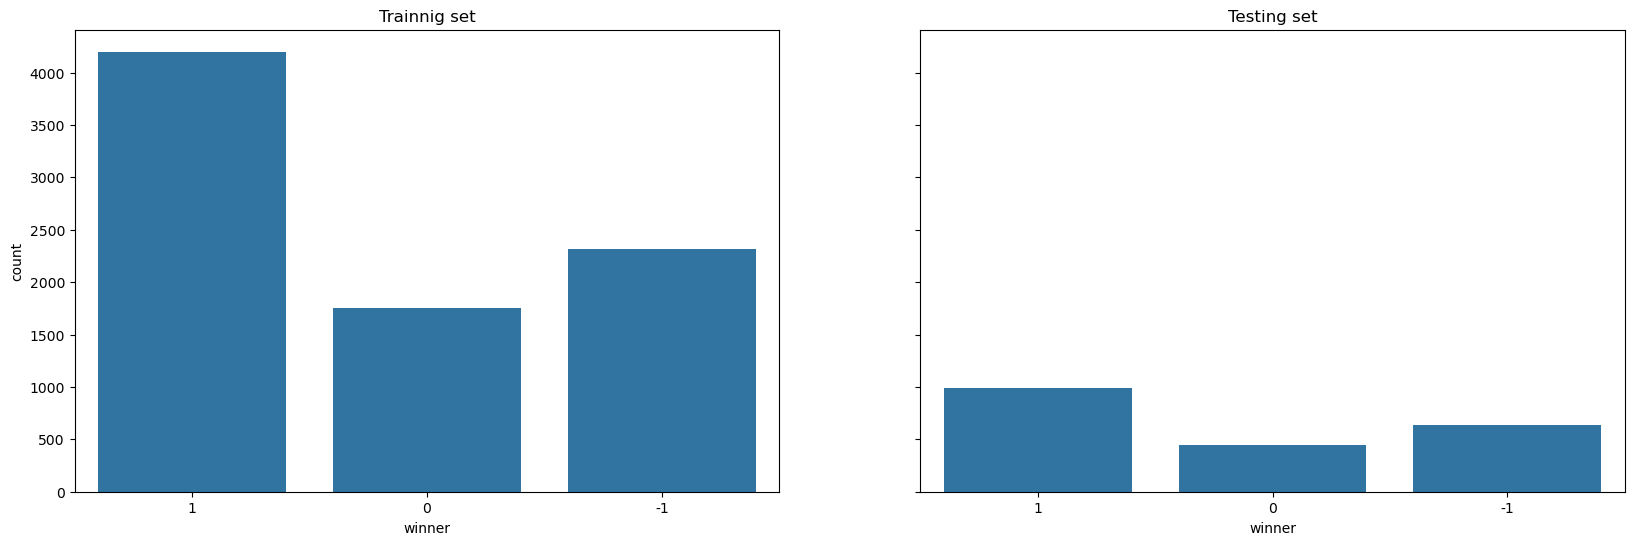

In [17]:
_, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
sns.countplot(train, x='winner', order=[1, 0, -1], ax=axs[0])
axs[0].set_title('Trainnig set')
sns.countplot(test, x='winner', order=[1, 0, -1], ax=axs[1])
axs[1].set_title('Testing set')

#### Create X and y

In [251]:
X = train.drop(['home_score', 'away_score', 'home_team', 'away_team', 'winner'], axis=1)
y = train.winner
Xt = test.drop(['home_score', 'away_score', 'home_team', 'away_team', 'winner'], axis=1)
yt = test.winner

<Axes: xlabel='winner', ylabel='count'>

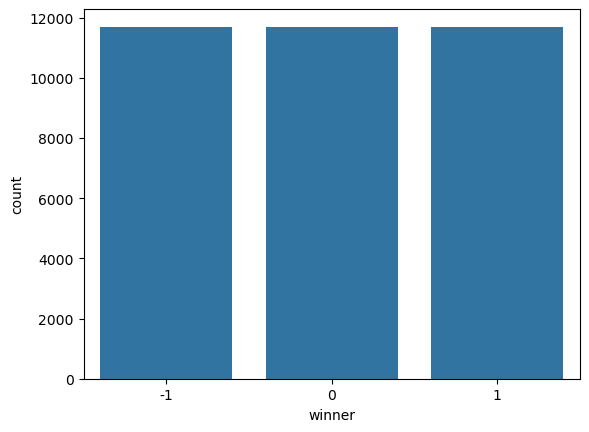

In [680]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

sns.countplot(pd.DataFrame({'winner': y_res}), x='winner')

In [252]:
# Scale the data
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
Xt_scaled = std_scaler.transform(Xt)

#### Create X and y with label encoder

In [253]:
# Encoder
lbl_encoder = LabelEncoder()
countries = set(df_input['home_team'].unique())
countries.update(set(df_input['away_team'].unique()))
lbl_encoder.fit(np.array(list(countries)))
# Scaler
std_scaler_cat = StandardScaler()
X_cat = train.drop(['home_score', 'away_score', 'winner'], axis=1)
X_cat['home_team'] = lbl_encoder.transform(X_cat['home_team'])
X_cat['away_team'] = lbl_encoder.transform(X_cat['away_team'])
X_cat_scaled = std_scaler_cat.fit_transform(X_cat)
Xt_cat = test.drop(['home_score', 'away_score', 'winner'], axis=1)
Xt_cat['home_team'] = lbl_encoder.transform(Xt_cat['home_team'])
Xt_cat['away_team'] = lbl_encoder.transform(Xt_cat['away_team'])
Xt_cat_scaled = std_scaler_cat.transform(Xt_cat)

#### X and y with PCA

In [254]:
pca = PCA(n_components=17)    # X_scaled.shape[1]
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_.cumsum())
Xt_pca = pca.transform(Xt_scaled)

[0.40544045 0.56565385 0.67505656 0.71799532 0.75402187 0.7844364
 0.80970737 0.83106494 0.85034978 0.86898014 0.88549988 0.90181032
 0.91302698 0.92361169 0.93404531 0.94415505 0.95322181]


In [255]:

# PCA input
oh_encoder = OneHotEncoder(drop='first')
oh_encoder.fit(df_input[['home_team', 'away_team']])
# Scaler
std_scaler_pca = StandardScaler()
X_pca_cat = train.drop(['home_score', 'away_score', 'winner', 'home_team', 'away_team'], axis=1)
X_pca_cat = pd.concat([X_pca_cat, pd.DataFrame(oh_encoder.transform(train[['home_team', 'away_team']]).toarray(), columns=oh_encoder.get_feature_names_out())], axis=1)
X_pca_cat = std_scaler_pca.fit_transform(X_pca_cat)
pca_cat = PCA(n_components=380) # X_pca.shape[1]
X_pca_cat = pca_cat.fit_transform(X_pca_cat)
# X_pca_cat_res, y_pca_res = SMOTE().fit_resample(X_pca_cat, y)
for i, cumsum in enumerate(pca_cat.explained_variance_ratio_.cumsum()):
    if cumsum > .95:
        print(i, cumsum)
        break
print(pca_cat.explained_variance_ratio_.cumsum()[-1])
Xt_pca_cat = test.drop(['home_score', 'away_score', 'winner', 'home_team', 'away_team'], axis=1).reset_index(drop=True)
Xt_pca_cat = pd.concat([Xt_pca_cat, pd.DataFrame(oh_encoder.transform(test[['home_team', 'away_team']]).toarray(), columns=oh_encoder.get_feature_names_out())], axis=1)
Xt_pca_cat = std_scaler_pca.transform(Xt_pca_cat)
Xt_pca_cat = pca_cat.transform(Xt_pca_cat)

0.9460709936629002


### Predicting the Winner

In [23]:
def plot_confusion_matrix(y_true, y_pred):
    print(type(y_true), type(y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()
    

#### Logistic Regression

In [60]:
params = {
    'solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
    'penalty':['l2', None]
}

lr_gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params, return_train_score=True)
lr_gs.fit(X, y)
lr_gs.best_params_

{'penalty': None, 'solver': 'newton-cg'}

In [258]:
lr_model = LogisticRegression(random_state=0, **{'penalty': 'l2', 'solver': 'newton-cg'})
# lf_selector = RFE(lr_model)
# lf_selector.fit_transform(X_cat, y)
lr_model.fit(X_pca_cat, y)

LogisticRegression(random_state=0, solver='newton-cg')

In [260]:
with open('models/lr_model.pkl','wb') as f:
    pkl.dump(lr_model,f)
# with open('models/lr_model.pkl','rb') as f:
#     lr_model = pkl.load(f)

              precision    recall  f1-score   support

          -1       0.59      0.58      0.58       635
           0       0.34      0.11      0.17       449
           1       0.64      0.84      0.72       986

    accuracy                           0.60      2070
   macro avg       0.52      0.51      0.49      2070
weighted avg       0.56      0.60      0.56      2070

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


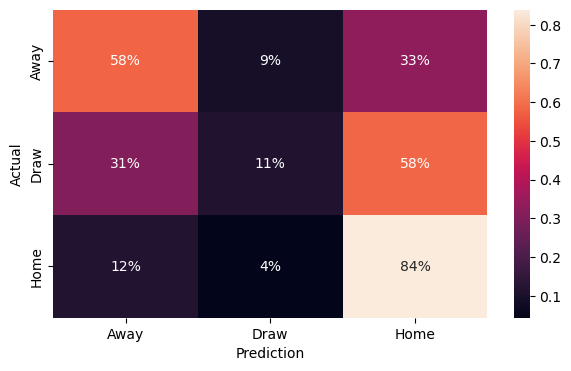

In [259]:
lr_preds = lr_model.predict(Xt_pca_cat)
print(classification_report(yt, lr_preds))
plot_confusion_matrix(yt, lr_preds)

The best model using logistic regression has a f1-score of [$0.59$, $0.11$, $0.72$] -> $0.6$

#### SVM (Support Vector Machine)

In [723]:
svm_model = LinearSVC()
clf_svm = CalibratedClassifierCV(svm_model)
clf_svm.fit(X_pca_cat, y)

CalibratedClassifierCV(estimator=LinearSVC())

              precision    recall  f1-score   support

          -1       0.68      0.46      0.55       632
           0       0.33      0.01      0.01       448
           1       0.57      0.94      0.71       987

    accuracy                           0.59      2067
   macro avg       0.53      0.47      0.42      2067
weighted avg       0.55      0.59      0.51      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


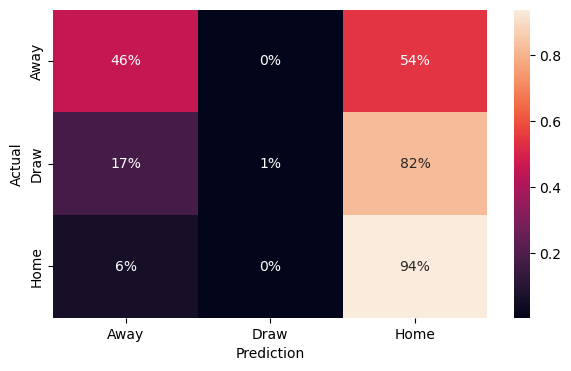

In [724]:
svm_preds = clf_svm.predict(Xt_pca_cat)
print(classification_report(yt, svm_preds))
plot_confusion_matrix(yt, svm_preds)

              precision    recall  f1-score   support

          -1       0.57      0.57      0.57      1748
           0       0.00      0.00      0.00      1398
           1       0.59      0.89      0.71      2855

    accuracy                           0.59      6001
   macro avg       0.39      0.48      0.43      6001
weighted avg       0.45      0.59      0.50      6001

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


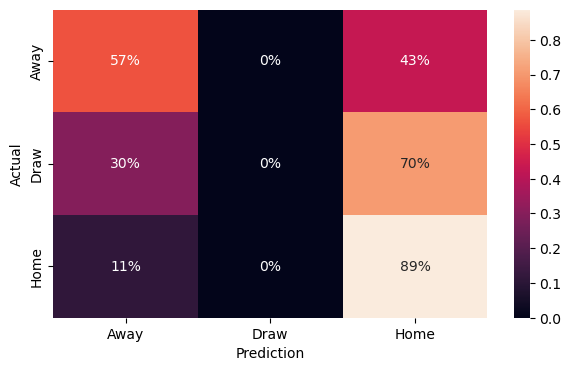

In [484]:
# Model witouth including the countries names
svm_model2 = SVC()
clf_svm2 = CalibratedClassifierCV(svm_model2)
clf_svm2.fit(X_pca, y)
svm_preds2 = clf_svm2.predict(Xt_pca)
print(classification_report(yt, svm_preds2))
plot_confusion_matrix(yt, svm_preds2)

#### Random Forest

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_pca_cat, y)

In [ ]:
imp = pd.DataFrame({'variables':X.columns, 'importance': rf_model.feature_importances_}).sort_values(by='importance', ascending=False)
imp[imp['importance'] > 0.001]['variables'].tolist()

In [726]:
importance_cutoff = 0.01
# rf_cols = imp[imp['importance'] > importance_cutoff]['variables'].tolist()
rf_model = RandomForestClassifier()
rf_model.fit(X_pca_cat, y)

RandomForestClassifier()

              precision    recall  f1-score   support

          -1       0.59      0.53      0.56       632
           0       0.27      0.15      0.19       448
           1       0.62      0.79      0.70       987

    accuracy                           0.57      2067
   macro avg       0.50      0.49      0.48      2067
weighted avg       0.54      0.57      0.55      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


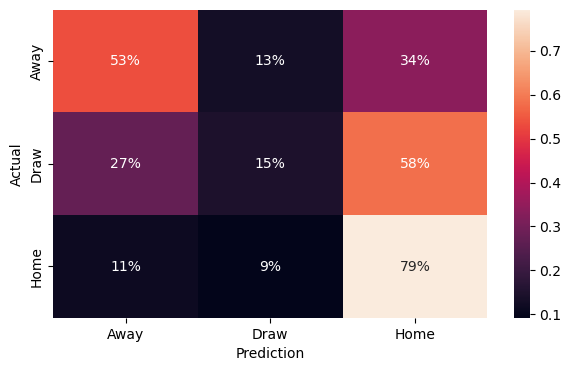

In [727]:
rf_preds = rf_model.predict(Xt_pca_cat)
print(classification_report(yt, rf_preds))
plot_confusion_matrix(yt, rf_preds)

#### CatBoost

In [729]:
cat_features = X.select_dtypes(include='object').columns.values
cat_features = []

cb_model = CatBoostClassifier(iterations=10000, learning_rate=0.55)
cb_model.fit(X_pca_cat, y, cat_features= cat_features, verbose=2000)

0:	learn: 0.9493985	total: 64.5ms	remaining: 10m 45s
2000:	learn: 0.1625751	total: 1m 34s	remaining: 6m 16s
4000:	learn: 0.1369506	total: 3m 12s	remaining: 4m 48s
6000:	learn: 0.1258478	total: 4m 52s	remaining: 3m 14s
8000:	learn: 0.1196948	total: 6m 34s	remaining: 1m 38s
9999:	learn: 0.1156445	total: 8m 17s	remaining: 0us


              precision    recall  f1-score   support

          -1       0.56      0.52      0.54       632
           0       0.28      0.19      0.23       448
           1       0.64      0.76      0.70       987

    accuracy                           0.57      2067
   macro avg       0.49      0.49      0.49      2067
weighted avg       0.54      0.57      0.55      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


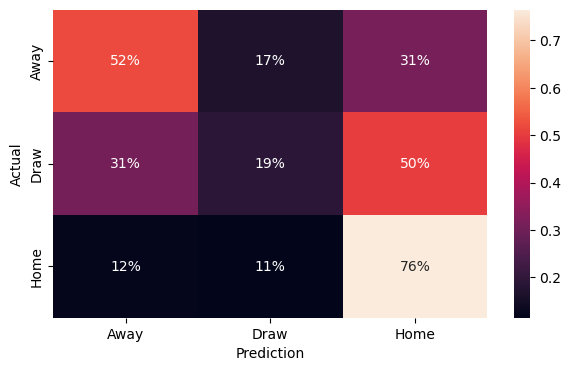

In [730]:
cb_preds = cb_model.predict(Xt_pca_cat)
print(classification_report(yt, cb_preds))
plot_confusion_matrix(yt, cb_preds)

#### Voting classifier

Between Logistic Regression and Random Forest

In [731]:
# Without the countries names
logit = LogisticRegression(max_iter=10000, multi_class='multinomial')
rf = RandomForestClassifier(criterion='entropy', n_estimators=600, max_depth=3)
voting_model = VotingClassifier(estimators=[('lr', logit), ('rf', rf)], voting='soft')
voting_model.fit(X_pca_cat, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=10000,
                                                 multi_class='multinomial')),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=3,
                                                     n_estimators=600))],
                 voting='soft')

              precision    recall  f1-score   support

          -1       0.65      0.53      0.58       632
           0       0.34      0.04      0.07       448
           1       0.60      0.91      0.72       987

    accuracy                           0.60      2067
   macro avg       0.53      0.49      0.46      2067
weighted avg       0.56      0.60      0.54      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


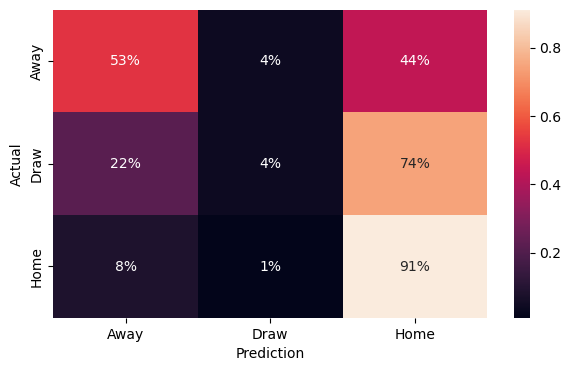

In [732]:
voting_preds = voting_model.predict(Xt_pca_cat)
print(classification_report(yt, voting_preds))
plot_confusion_matrix(yt, voting_preds)

#### Neural Network

In [26]:
# Check GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [27]:
def plot_accuracy(history: tf.keras.callbacks.History) -> None:
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title("Accuracy vs. Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc="lower right")
    plt.show()

##### Model 1

Simple ANN with
1. Input layer with 128 nuerons and activation RELU
2. Dropout layer $.2$
3. Hidden layer with 64 neurons and actication RELU
4. Dropout layer $.2$
5. Output layer with activation sigmoid

In [ ]:
# Set the input shape for the NN
input_shape = X_pca_cat.shape[1]
backend.clear_session()

In [101]:
# backend.clear_session()
model1 = Sequential()
model1.add(Dense(16, activation="tanh", input_shape=(input_shape, )))
model1.add(Dropout(.2))
model1.add(Dense(24, activation="tanh"))
model1.add(Dense(32, activation="tanh"))
model1.add(Dropout(.1))
model1.add(Dense(3, activation="softmax"))
# For classification tasks, we can minimize binary_crossent loss
model1.compile(loss="categorical_crossentropy", metrics=["accuracy", 'categorical_accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=.001, decay=0.0))
model1.summary()
history1 = model1.fit(X_pca_cat, pd.get_dummies(y), validation_split=.1, epochs=10, verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                6096      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 24)                408       
                                                                 
 dense_10 (Dense)            (None, 32)                800       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 7,403
Trainable params: 7,403
Non-traina

In [103]:
model1.save('./models/model1.h5')

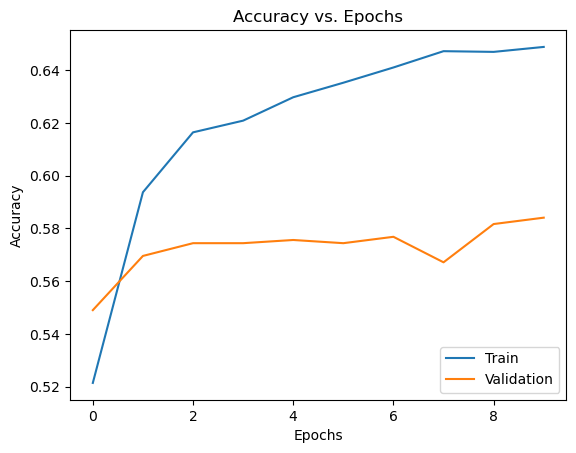

65/65 [==============================] - 0s 2ms/step
[[366  50 216]
 [118  55 275]
 [114  51 822]]
              precision    recall  f1-score   support

          -1       0.61      0.58      0.60       632
           0       0.35      0.12      0.18       448
           1       0.63      0.83      0.71       987

    accuracy                           0.60      2067
   macro avg       0.53      0.51      0.50      2067
weighted avg       0.56      0.60      0.56      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


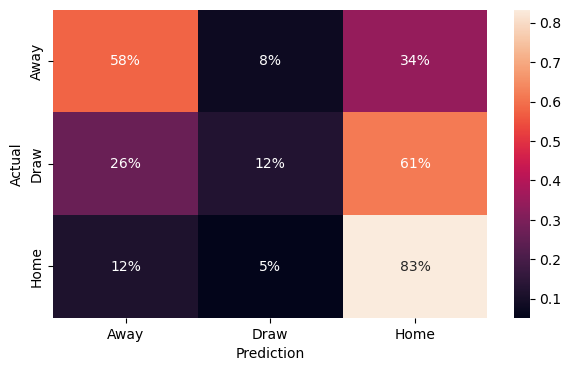

In [102]:
plot_accuracy(history1)
model1_preds = model1.predict(Xt_pca_cat)
print(confusion_matrix(yt, np.argmax(model1_preds, axis=1)-1))
print(classification_report(yt, np.argmax(model1_preds, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(model1_preds, axis=1)-1)

##### Model 2

In [127]:
# Clear tf session
# backend.clear_session()
model2 = Sequential()
model2.add(Dense(128, activation="tanh", input_shape=(input_shape, )))
model2.add(Dropout(.6))
model2.add(Dense(128, activation="tanh"))
model2.add(Dropout(.6))
#model2.add(Dense(32, activation="tanh"))
model2.add(Dense(3, activation="softmax"))
# For classification tasks, we can minimize binary_crossent loss
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", 'categorical_accuracy'])
model2.summary()
history2 = model2.fit(X_pca_cat, pd.get_dummies(y), validation_split=.1, epochs=20)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               48768     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 65,667
Trainable params: 65,667
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
233/233 [==============================

In [261]:
# model2.save('./models/model2_v2.h5')
model2 = tf.keras.models.load_model('./models/model2.h5')

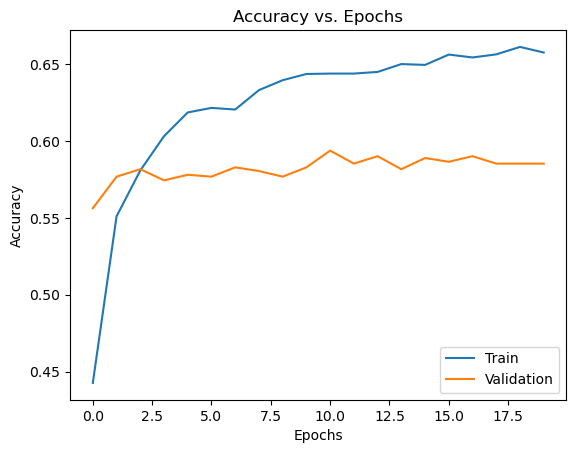

65/65 [==============================] - 0s 2ms/step
[[384  72 176]
 [145  67 236]
 [120  61 806]]
              precision    recall  f1-score   support

          -1       0.59      0.61      0.60       632
           0       0.34      0.15      0.21       448
           1       0.66      0.82      0.73       987

    accuracy                           0.61      2067
   macro avg       0.53      0.52      0.51      2067
weighted avg       0.57      0.61      0.58      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


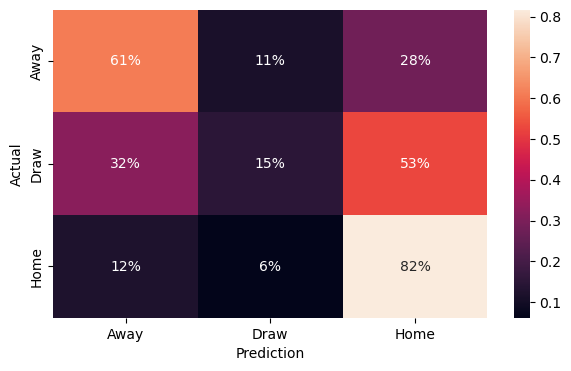

In [128]:
plot_accuracy(history2)
model2_preds = model2.predict(Xt_pca_cat)
print(confusion_matrix(yt, np.argmax(model2_preds, axis=1)-1))
print(classification_report(yt, np.argmax(model2_preds, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(model2_preds, axis=1)-1)

##### Model 3: LSTM

In [33]:
# Clear tf session
# backend.clear_session()
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, input_shape), dropout=.6))
# lstm.add(LSTM(32, return_sequences=True, activation='tanh'))
# lstm.add(LSTM(32, activation='sigmoid'))
lstm.add(Dense(3, activation='softmax'))
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
lstm.summary()
history3 = lstm.fit(X_pca_cat.reshape(-1, 1, input_shape), pd.get_dummies(y), epochs=10, verbose=2, validation_split=.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                113920    
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 114,115
Trainable params: 114,115
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
207/207 - 6s - loss: 1.0301 - accuracy: 0.4828 - categorical_accuracy: 0.4828 - val_loss: 0.9723 - val_accuracy: 0.5447 - val_categorical_accuracy: 0.5447 - 6s/epoch - 27ms/step
Epoch 2/10
207/207 - 1s - loss: 0.9538 - accuracy: 0.5516 - categorical_accuracy: 0.5516 - val_loss: 0.9488 - val_accuracy: 0.5623 - val_categorical_accuracy: 0.5623 - 783ms/epoch - 4ms/step
Epoch 3/10
207/207 - 1s - loss: 0.9324 - accuracy: 0.5674 - cate

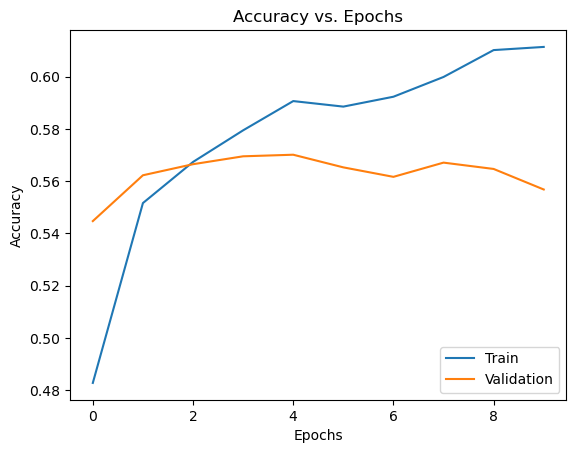

65/65 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

          -1       0.57      0.56      0.57       632
           0       0.32      0.13      0.19       448
           1       0.63      0.81      0.71       987

    accuracy                           0.59      2067
   macro avg       0.51      0.50      0.49      2067
weighted avg       0.55      0.59      0.55      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


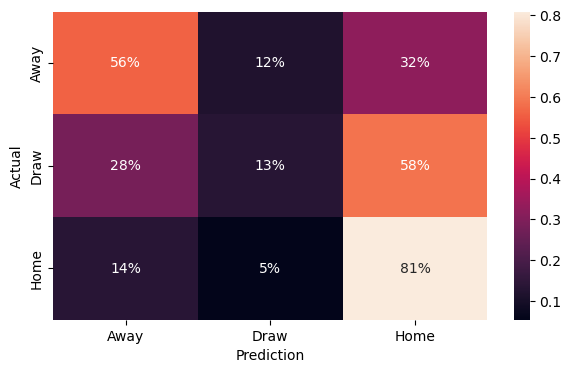

In [34]:
plot_accuracy(history3)
lstm_preds = lstm.predict(Xt_pca_cat.reshape(-1, 1, input_shape))
print(classification_report(yt, np.argmax(lstm_preds, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(lstm_preds, axis=1)-1)

### Combination of models

In [130]:
def comb_predict(in_data: np.ndarray) -> np.ndarray:
    return ((lr_model.predict_proba(in_data) + model1.predict(in_data) + model1.predict(in_data)) / 3)

65/65 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

          -1       0.60      0.57      0.59       632
           0       0.36      0.12      0.18       448
           1       0.63      0.84      0.72       987

    accuracy                           0.60      2067
   macro avg       0.53      0.51      0.50      2067
weighted avg       0.56      0.60      0.56      2067

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


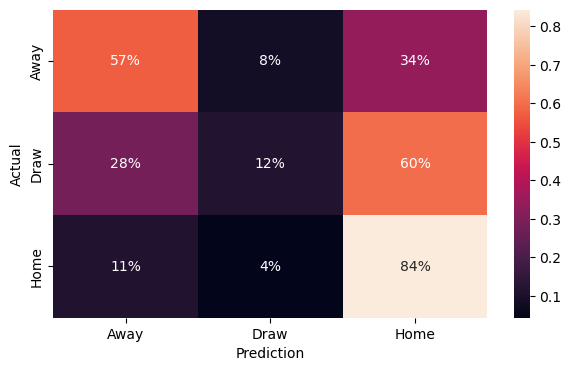

In [131]:
comb_pred = comb_predict(Xt_pca_cat)
print(classification_report(yt, np.argmax(comb_pred, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(comb_pred, axis=1)-1)

### Testing predictions

In [35]:
def create_input(matches: pd.DataFrame) -> pd.DataFrame:
    df_input = matches[['home_team', 'away_team', 'is_official', 'neutral', 'h2h']]
    return df_input.merge(important_performance, left_on='home_team', right_on='team', how='left').fillna(0).merge(
        important_performance, left_on='away_team', right_on='team', how='left', suffixes=['_home', '_away']).fillna(0).drop(
            ['team_home', 'team_away'], axis=1)


In [94]:
def create_input_pca_cat(info: pd.DataFrame) -> np.ndarray:
    info_pca_cat = info.drop(['home_team', 'away_team'], axis=1)
    info_pca_cat = pd.concat([info_pca_cat, pd.DataFrame(oh_encoder.transform(info[['home_team', 'away_team']]).toarray(), columns=oh_encoder.get_feature_names_out())], axis=1)
    info_pca_cat = std_scaler_pca.transform(info_pca_cat)
    return pca_cat.transform(info_pca_cat)

In [113]:

# Logistic Regression
t_in_df = create_input(pd.DataFrame({
              'home_team': ['Germany', 'Hungary'], 
              'away_team': ['Scotland', 'Switzerland'],
              'is_official': [7, 7], 
              'neutral': [0, 1],
              'h2h': [6, -12]}))
t_in = t_in_df.drop(['home_team', 'away_team'], axis=1)
t_in_scaled = std_scaler.transform(t_in)
t_in_cat = t_in_df.copy()
t_in_cat['home_team'] = lbl_encoder.transform(t_in_cat['home_team'])
t_in_cat['away_team'] = lbl_encoder.transform(t_in_cat['away_team'])
t_in_cat_scaled = std_scaler_cat.transform(t_in_cat)
t_in_pca = pca.transform(t_in_scaled)
t_in_pca_cat = t_in_df.drop(['home_team', 'away_team'], axis=1)
t_in_pca_cat = pd.concat([t_in_pca_cat, pd.DataFrame(oh_encoder.transform(t_in_df[['home_team', 'away_team']]).toarray(), columns=oh_encoder.get_feature_names_out())], axis=1)
t_in_pca_cat = std_scaler_pca.transform(t_in_pca_cat)
t_in_pca_cat = pca_cat.transform(t_in_pca_cat)

In [120]:
((lr_model.predict_proba(t_in_pca_cat) + model1.predict(t_in_pca_cat) + model1.predict(t_in_pca_cat)) / 3)

1/1 [==============================] - 0s 19ms/step


array([[0.037491  , 0.08273885, 0.87977018],
       [0.38073195, 0.25322317, 0.36604488]])

In [134]:
# Testing Logistic Regression
lr_model.predict_proba(t_in_pca_cat)

array([[0.0583177 , 0.1272247 , 0.8144576 ],
       [0.41978063, 0.24897566, 0.33124371]])

In [133]:
# Testing NN model 1
model1.predict(t_in_pca_cat)

1/1 [==============================] - 0s 37ms/step


array([[0.02707765, 0.06049592, 0.9124265 ],
       [0.3612076 , 0.25534692, 0.38344547]], dtype=float32)

In [132]:
# Testing NN model 2
model2.predict(t_in_pca_cat)

1/1 [==============================] - 0s 37ms/step


array([[0.01695671, 0.05739969, 0.92564356],
       [0.4104451 , 0.26553884, 0.32401612]], dtype=float32)

In [107]:
# Testing LSTM model 3
lstm.predict(t_in_pca_cat.reshape(-1, 1, input_shape))

1/1 [==============================] - 0s 23ms/step


array([[0.12640522, 0.21338323, 0.66021156],
       [0.31622857, 0.23387061, 0.44990084]], dtype=float32)

### Predicting Goals

In [44]:
home_goals = res[['home_team','home_score', 'away_score']].rename(columns={'home_team': 'team', 'home_score': 'gf', 'away_score': 'ga'})
home_goals['total'] = home_goals.gf + home_goals.ga
away_goals = res[['away_team','home_score', 'away_score']].rename(columns={'away_team': 'team', 'home_score': 'ga', 'away_score': 'gf'})
away_goals['total'] = away_goals.gf + away_goals.ga

goals = pd.concat([home_goals, away_goals], ignore_index=True).groupby('team').mean().reset_index()
# Adding performance to df_goals
goals = goals.merge(important_performance[['team','performance']], on='team', how='left').fillna(0)
# Adding strength
goals['strength'] = goals['gf'] / goals['ga']
goals.sample(3)

,team,gf,ga,total,performance,strength
127,Mozambique,0.863636,1.409091,2.272727,0.272727,0.612903
8,Argentina,2.000000,0.945534,2.945534,0.584435,2.115207
41,China PR,2.082707,0.842105,2.924812,0.555556,2.473214


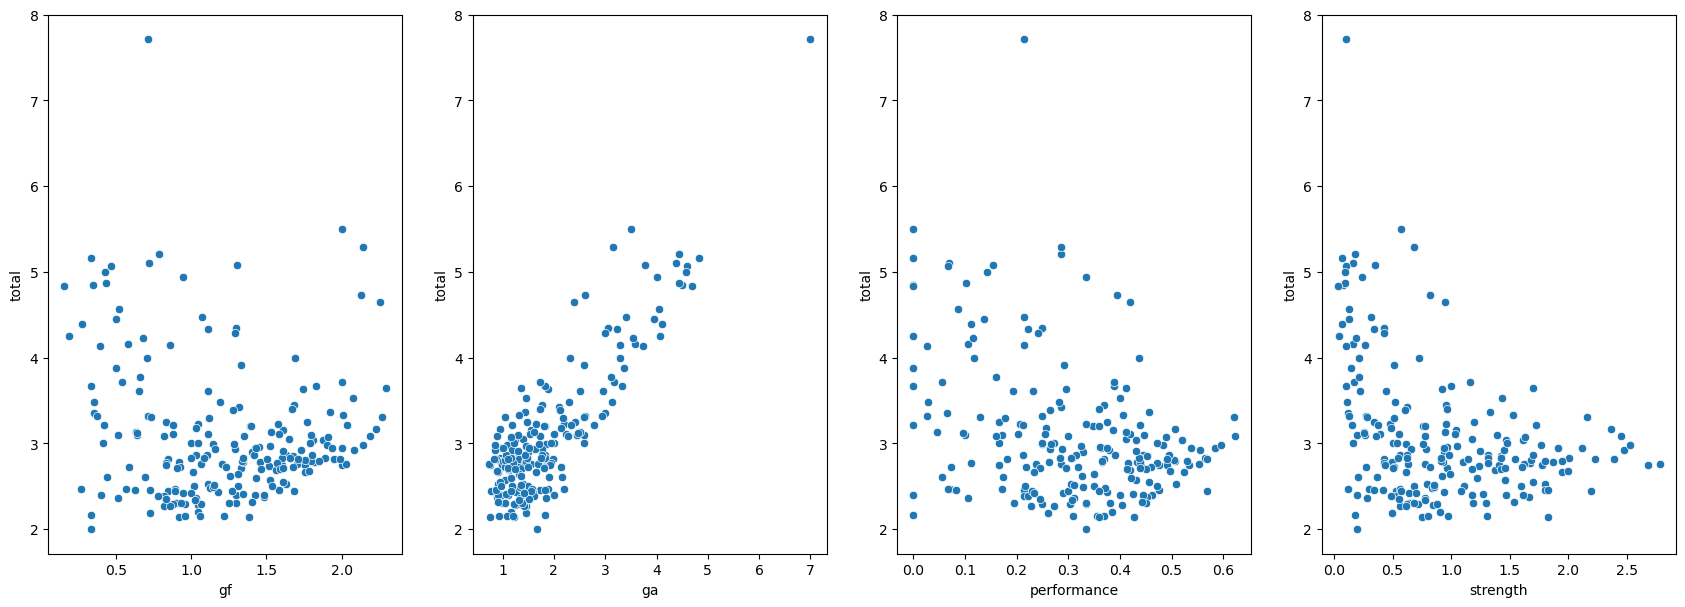

In [45]:
plt.figure(figsize=(21,7))
plt.subplot(141)
sns.scatterplot(data=goals, x='gf', y='total')
plt.subplot(142)
sns.scatterplot(data=goals, x='ga', y='total')
plt.subplot(143)
sns.scatterplot(data=goals, x='performance', y='total')
plt.subplot(144)
sns.scatterplot(data=goals, x='strength', y='total');

In [205]:
goals[goals.select_dtypes(exclude=['object']).columns.values].corr().style.background_gradient(cmap='coolwarm')

,gf,ga,total,performance,strength
gf,1.000000,-0.610802,-0.124683,0.866534,0.863786
ga,-0.610802,1.000000,0.861761,-0.732850,-0.738223
total,-0.124683,0.861761,1.000000,-0.363138,-0.371631
performance,0.866534,-0.732850,-0.363138,1.000000,0.906280
strength,0.863786,-0.738223,-0.371631,0.906280,1.000000


In [252]:
goals[['gf', 'ga']].agg(('mean', 'std')).T

,mean,std
gf,1.226483,0.513446
ga,1.862806,1.004190


### Create model

In [46]:
Xg = goals.drop(['team','total'], axis=1)
yg = goals.total

In [47]:
goal_model = SVR(C=1.0, kernel='poly', degree=1)
goal_model.fit(Xg, yg)
rmse = np.sqrt( mean_squared_error( y_true=yg,
                            y_pred= goal_model.predict(Xg)) )
rmse

0.051768693396913125

In [49]:
# Variance of RMSE over the original mean
rmse / goals.total.mean()

0.016757478398311463

In [156]:

def create_goals_input(teams: pd.Series) -> pd.Series:
    game = goals[goals['team'].isin(teams.tolist())].drop(['team', 'total'], axis=1).reset_index(drop=True)
    return pd.Series([(game.iloc[0, 0] + game.iloc[1, 1])/2, (game.iloc[0, 0] + game.iloc[1, 1])/2] + game.iloc[:, 2:].mean(axis=0).tolist(), index=game.columns.values)

In [51]:
t_in_df[['home_team', 'away_team']].apply(create_goals_input, axis=1)

,gf,ga,performance,strength
0,1.719145,1.719145,0.521271,1.690334
1,1.580603,1.580603,0.434681,1.253100


In [206]:
game = goals[goals['team'].isin(['Brazil', 'Italy'])].drop(['team', 'total'], axis=1).reset_index(drop=True)
game.loc[game.shape[0]] = [game.iloc[0, 0] * game.iloc[1, 1], game.iloc[0, 0] * game.iloc[1, 1]] + game.iloc[:, 2:].mean(axis=0).tolist()
game

,gf,ga,performance,strength
0,2.191083,0.895966,0.622775,2.445498
1,1.681102,0.767717,0.568075,2.189744
2,1.682130,1.682130,0.595425,2.317621


In [258]:
lr_model.predict_proba(t_in_pca_cat)

array([[0.0364485 , 0.1414742 , 0.8220773 ],
       [0.5658511 , 0.2369514 , 0.19719749]])

In [163]:
goal_model.predict(t_in_df[['home_team', 'away_team']].apply(create_goals_input, axis=1))

array([3.47257688, 3.18519117])

In [229]:
def calculate_result(match: pd.Series) -> pd.Series:
    goal_in = create_goals_input(match[['home_team', 'away_team']])
    goals = goal_model.predict([goal_in])[0]
    winner = np.argmax(match[['Home', 'Draw', 'Away']])
    
    if goals <= 2 and winner != 1:
        return pd.Series([goals, max(0, -(winner - 1))*max(np.floor(goals), 1), max(0, (winner - 1)*max(np.floor(goals), 1))])
    elif winner == 1:
        g = np.max(match[['Home', 'Away']] * goals)
        return pd.Series([goals, round(g), round(g)])
    prob_home, prob_away = match[['Home', 'Away']] / match[['Home', 'Away']].sum()
    return pd.Series([goals, np.round(np.round(goals) * match['Home']), np.round(np.round(goals) * match['Away'])])

#### UEFA Euro 2024

In [262]:
euros = df[(df.date >= '2024-06-19') & (df['tournament']=='UEFA Euro') & (~df.home_team.isnull())].copy()
euros['is_official'] = euros['tournament'].apply(lambda x: official.get(x, 1))
euros['h2h'] = euros.apply(h2h, axis=1)
euros = create_input(euros[['home_team', 'away_team', 'is_official', 'neutral', 'h2h']])
euros_pca = create_input_pca_cat(euros)

In [263]:
lr_euro_preds = pd.concat([euros[['home_team', 'away_team']].reset_index(drop=True), pd.DataFrame(lr_model.predict_proba(euros_pca), columns=['Away', 'Draw', 'Home'])[['Home', 'Draw', 'Away']]], axis=1)
lr_euro_preds[['Total', 'Home_Goals', 'Away_Goals']] = lr_euro_preds.apply(calculate_result, axis=1)
lr_euro_preds

,home_team,away_team,Home,Draw,Away,Total,Home_Goals,Away_Goals
0,Germany,Hungary,0.708856,0.196412,0.094732,3.730704,3.0,0.0
1,Scotland,Switzerland,0.360586,0.373009,0.266406,2.723572,1.0,1.0
2,Croatia,Albania,0.810620,0.159107,0.030273,1.748810,1.0,0.0
3,Spain,Italy,0.340673,0.356336,0.302991,2.649810,1.0,1.0
4,Slovenia,Serbia,0.122279,0.136727,0.740995,3.119009,0.0,2.0
5,Denmark,England,0.192005,0.345226,0.462768,2.551807,1.0,1.0
6,Poland,Austria,0.527278,0.344698,0.128023,2.897588,2.0,0.0
7,Netherlands,France,0.419256,0.340153,0.240591,2.857775,1.0,1.0
8,Slovakia,Ukraine,0.115290,0.304527,0.580183,2.612025,0.0,2.0
9,Belgium,Romania,0.517020,0.174791,0.308189,3.046033,2.0,1.0


In [264]:
m2_euro_preds = pd.concat([euros[['home_team', 'away_team']].reset_index(drop=True), pd.DataFrame(model2.predict(euros_pca), columns=['Away', 'Draw', 'Home'])[['Home', 'Draw', 'Away']]], axis=1)
m2_euro_preds[['Total', 'Home_Goals', 'Away_Goals']] = m2_euro_preds.apply(calculate_result, axis=1)
m2_euro_preds

2/2 [==============================] - 0s 20ms/step


,home_team,away_team,Home,Draw,Away,Total,Home_Goals,Away_Goals
0,Germany,Hungary,0.903133,0.059344,0.037523,3.730704,4.0,0.0
1,Scotland,Switzerland,0.432757,0.229082,0.338161,2.723572,1.0,1.0
2,Croatia,Albania,0.947674,0.036446,0.015880,1.748810,1.0,0.0
3,Spain,Italy,0.313983,0.382318,0.303699,2.649810,1.0,1.0
4,Slovenia,Serbia,0.024415,0.134320,0.841265,3.119009,0.0,3.0
5,Denmark,England,0.078697,0.129947,0.791355,2.551807,0.0,2.0
6,Poland,Austria,0.588601,0.202354,0.209045,2.897588,2.0,1.0
7,Netherlands,France,0.585255,0.350201,0.064543,2.857775,2.0,0.0
8,Slovakia,Ukraine,0.100375,0.177652,0.721973,2.612025,0.0,2.0
9,Belgium,Romania,0.346582,0.346283,0.307135,3.046033,1.0,1.0


In [237]:
# Later rounds
rounds_df = pd.read_csv('data/results.csv', parse_dates=['date'])
rounds = rounds_df[(rounds_df.date >= '2024-06-29') & (rounds_df['tournament']=='UEFA Euro') & (~rounds_df.home_team.isnull())].copy()
rounds['is_official'] = rounds['tournament'].apply(lambda x: official.get(x, 1))
rounds['h2h'] = rounds.apply(h2h, axis=1)
rounds = create_input(rounds[['home_team', 'away_team', 'is_official', 'neutral', 'h2h']])
rounds_pca = create_input_pca_cat(rounds)

rounds_euro_preds = pd.concat([rounds[['home_team', 'away_team']].reset_index(drop=True), pd.DataFrame(lr_model.predict_proba(rounds_pca), columns=['Away', 'Draw', 'Home'])[['Home', 'Draw', 'Away']]], axis=1)
rounds_euro_preds[['Total', 'Home_Goals', 'Away_Goals']] = rounds_euro_preds.apply(calculate_result, axis=1)
rounds_euro_preds

,home_team,away_team,Home,Draw,Away,Total,Home_Goals,Away_Goals
0,Croatia,Ukraine,0.251538,0.368812,0.379651,2.639644,1.0,1.0
1,Germany,Serbia,0.591074,0.204218,0.204707,3.484754,2.0,1.0
2,Portugal,Denmark,0.588722,0.230900,0.180379,2.756563,2.0,1.0
3,France,Romania,0.651049,0.190350,0.158602,3.069716,2.0,0.0
4,Belgium,Spain,0.220950,0.184311,0.594739,2.814292,1.0,2.0
5,Netherlands,Czech Republic,0.449888,0.327533,0.222579,2.700747,1.0,1.0
6,England,Poland,0.711201,0.134126,0.154673,3.292668,2.0,0.0
7,Scotland,Italy,0.118999,0.405084,0.475917,2.928950,0.0,1.0
8,Germany,Ukraine,0.613036,0.275576,0.111388,3.244756,2.0,0.0
9,Portugal,France,0.478201,0.284703,0.237096,2.975590,1.0,1.0
